In [6]:
GOOGLE = False
if GOOGLE:
    from google.colab import drive
    drive.mount('/content/drive')

In [18]:
from shared.data_loader import *
from shared.utils import *

In [20]:
# GPU code
import torch
import torch.nn.functional as F

# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Please set GPU via Edit -> Notebook Settings.


In [53]:
# EEG DATA
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
import pandas as pd

class EEG_Data(Dataset):

    def __init__(self, root_dir, split, preprocess=lambda x,y:train_data_prep(x,y,2,2,True), transform=None, label_dict=None):
        """
        Initialize the eeg dataset with the root directory for the images,
        the split (train/val/test), an optional data transformation,
        and an optional label dictionary.

        Args:
            root_dir (str): Root directory for the eeg images.
            split (str): Split to use ('train', 'val', or 'test').
            transform (callable, optional): Optional data transformation to apply to the images.
            label_dict (dict, optional): Optional dictionary mapping integer labels to class names.
        """
        assert split in ['train', 'val', 'test']
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.datastorch = []
        self.labels = []
        self.label_dict = ["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"]

        ################# Your Implementations #################################
        if self.split == 'train':
            # First generating the training and validation indices using random splitting
            X_train_valid = np.load(self.root_dir+"X_train_valid.npy")
            y_train_valid = np.load(self.root_dir+"y_train_valid.npy")

            np.random.seed(0)
            data_length = len(X_train_valid)

            ind_valid = np.random.choice(data_length, int(data_length*0.1), replace=False)
            ind_train = np.array(list(set(range(data_length)).difference(set(ind_valid))))

            # Creating the training and validation sets using the generated indices
            (x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
            (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

            if preprocess is not None:
                x_train,y_train = preprocess(x_train,y_train)

            self.datas = torch.from_numpy(x_train)
            self.labels = [int(i-769) for i in torch.from_numpy(y_train)]

        if self.split == 'val':
            # First generating the training and validation indices using random splitting
            X_train_valid = np.load(self.root_dir+"X_train_valid.npy")
            y_train_valid = np.load(self.root_dir+"y_train_valid.npy")

            data_length = len(X_train_valid)

            np.random.seed(0)
            ind_valid = np.random.choice(data_length, int(data_length*0.1), replace=False)
            ind_train = np.array(list(set(range(data_length)).difference(set(ind_valid))))

            # Creating the training and validation sets using the generated indices
            (x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
            (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

            if preprocess is not None:
                x_valid,y_valid = preprocess(x_valid,y_valid)

            self.datas = torch.from_numpy(x_valid)
            self.labels = [int(i-769) for i in torch.from_numpy(y_valid)]

        if self.split == 'test':
            x_test = np.load(self.root_dir+"X_test.npy")
            # x_test = test_data_prep(x_test_og)  # (2115, 1)  vals from 0-8 for participant
            if preprocess is not None:
                x_test = preprocess(x_test)
            y_test = np.load(self.root_dir+"y_test.npy")  # (443, 1)
            self.datas = torch.from_numpy(x_test)
            self.labels = [int(i-769) for i in torch.from_numpy(y_test)]

        ################# End of your Implementations ##########################

    def __len__(self):
        """
        Return the number of images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        dataset_len = 0
        ################# Your Implementations #################################
        # Return the number of images in the dataset
        dataset_len = len(self.datas)
        ################# End of your Implementations ##########################
        return dataset_len

    def __getitem__(self, idx):
        """
        R10140    idx (int): Index of the image to retrieve.

        Returns:
            tuple: Tuple containing the image and its label.
        """
        ################# Your Implementations #################################
        # Load and preprocess image using self.root_dir,
        # self.filenames[idx], and self.transform (if specified)

        data = self.datas[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(data)
        ################# End of your Implementations ##########################
        return data, label

In [1]:
# Convolution

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class ConvBlock(nn.Module):
    def __init__(self, input_size, output_size, kernel_size, dropout=0.6):
        super().__init__()
        padding = (kernel_size-1)//2
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=output_size, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, padding=1),
            nn.BatchNorm1d(output_size),
            nn.Dropout(dropout)
        )
    def forward(self, x, **kwargs):
        # keey the residual connection here
        return self.conv_block.forward(x)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, downsample=False, dropout=0.6):
        '''
        Initialize a basic residual block.
        Depending on whether downsample is True, there are two types of basic blocks in Resnet 18,
        one to downsample the input and the other maintains the same size.
        You can use Pytorch's functions.

        Input and output shapes of each layer:
        1) conv1 (3*3 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H, W) if downsample=False
           conv1 (3*3 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) if downsample=True, with stride of 2
        2) conv2 (3*3 kernel, no bias): (batch_size, out_channels, H, W) -> (batch_size, out_channels, H, W)
        3) conv3 (optional) if downsample=True (1*1 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) with stride of 2
        '''
        super().__init__()
        ################# Your Implementations #################################
        self.downsample = downsample
        if (in_channels != out_channels):
           self.downsample = True
        self.kernel_size = kernel_size
        self.dropout = dropout
        # self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, bias=False, padding=1) #(128 - 3 + 2*1)//2 + 1
        self.conv2 = nn.Sequential(
                        nn.Conv1d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False),
                        nn.BatchNorm1d(out_channels))
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.relu2 = nn.ReLU()
        if self.downsample:
          self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False) #(128 - 3 + 2*1)//2 + 1
          self.conv3 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False) #(128 - 3 + 2*1)//2 + 1
        else:
          self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False) #(128 - 3 + 2*1)//2 + 1

        ################# End of your Implementations ##########################

    def forward(self, x):
        """
        Forward pass of the basic residual block.
        The input tensor 'x' should pass through the following layers:
        1) conv1: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H, W)
           conv1: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) if downsample=True
        2) Apply batch normalization after conv1.
        3) Apply relu activation.
        4) conv2: (batch_size, out_channels, H, W) -> (batch_size, out_channels, H, W)
        5) Apply batch normalization after conv2.
        6) (Optional) if downsample=True, conv3: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) on the original input
        7) (Optional) if downsample=True, apply batch normalization after conv3.
        8) Add the residual value to the original input
        9) Apply relu activation in the end.
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the basic residual block.
        og=x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample:
          og = self.conv3(og)
          og = self.bn3(og)
        x += og
        x =self.relu2(x)
        x = nn.Dropout(self.dropout)(x)
        ################# End of your Implementations ##########################
        return x

fc_block = lambda i, o : nn.Linear(i,o)




In [88]:
# Data loading
data_root = "../project_data/project/"
if GOOGLE:
    data_root = "/content/drive/MyDrive/project/"
data_transform =  lambda x: x.reshape(1,x.shape[0],x.shape[1]) # fft transformation
data_transform = lambda x: abs(np.fft.fft(x))
data_transform = lambda x : scale_high_freq(x, 0.06, 0.4)
data_transform =  lambda x: x.reshape(1,x.shape[0],x.shape[1]) # fft transformation
data_transform = lambda x:x.T
# Create eeg dataset object
eeg_train = EEG_Data(data_root,
                              split='train',
                              preprocess=lambda x,y:train_data_prep(x,y,2,2,True),
                              transform=data_transform)

eeg_val = EEG_Data(data_root,
                            split='val',
                            preprocess=lambda x,y:train_data_prep(x,y,2,2,True),
                            transform=data_transform)
eeg_test = EEG_Data(data_root,
                            split='test',
                            preprocess=lambda x:test_data_prep(x),
                            transform=None)
print("val split: ", len(eeg_val))
print("train split: ", len(eeg_train))
# Create the dataloaders
# Define the batch size and number of workers
batch_size = 64
num_workers=2
# Create DataLoader for training and validation sets
train_loader = DataLoader(eeg_train,
                          batch_size=batch_size,
                          num_workers=num_workers,
                        shuffle=True)
val_loader = DataLoader(eeg_val,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=False)
test_loader = DataLoader(eeg_test,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=False)

Shape of X after trimming: (1904, 22, 800)
Shape of X after maxpooling: (1904, 22, 400)
Shape of X after averaging+noise and concatenating: (3808, 22, 400)
Shape of X after subsampling and concatenating: (7616, 22, 400)
Shape of Y: (7616,)
Shape of X after trimming: (211, 22, 800)
Shape of X after maxpooling: (211, 22, 400)
Shape of X after averaging+noise and concatenating: (422, 22, 400)
Shape of X after subsampling and concatenating: (844, 22, 400)
Shape of Y: (844,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
val split:  844
train split:  7616


In [74]:
class LSTMBlock(nn.Module):
    def __init__(self, input_size, hidden_layer_dim, hidden_layer):
        super().__init__()
        self.LSTM = nn.LSTM(input_size, hidden_layer_dim, hidden_layer)

    def forward(self, x, **kwargs):
        # keey the residual connection here
        out, (hn, cn) = self.LSTM(x)

        return hn[-1]


In [91]:

class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [h0,c0]



In [43]:
convnet =  nn.Sequential(
    ConvBlock(22,25,5),
    ConvBlock(25,50,5),
    ConvBlock(50,100,5),
    ConvBlock(100,200,5),
    nn.Flatten(start_dim=1),
    fc_block(2600, 40),
    nn.BatchNorm1d(40),
    nn.ReLU(),
    LSTMBlock(40, 10, 2),
    fc_block(10,4)
)



In [64]:
resnet =  nn.Sequential(
    ConvBlock(22,25,2,0),
    ConvBlock(25,50,5,0),
    ResBlock(50,128,5,0),
    nn.Flatten(start_dim=1),
    fc_block(5760, 500),
    nn.ReLU(),
    fc_block(500, 40),
    nn.ReLU(),
    fc_block(40,4)
)

In [71]:
resnetv2 =  nn.Sequential(
    nn.Conv1d(in_channels=22, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),
    nn.BatchNorm1d(64),
    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),
    nn.BatchNorm1d(128),
    ResBlock(128,256,3,0),
    nn.MaxPool1d(kernel_size=2),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Flatten(start_dim=1),
    fc_block(12800, 512),
    nn.ReLU(),
    fc_block(512,4)
)


In [92]:
lstmnet =  nn.Sequential(
    LSTMClassifier(22, 256, 3, 4)
)

In [13]:
convnet3 =  nn.Sequential(
    nn.Conv1d(in_channels=22, out_channels=20, kernel_size=2, padding=1, dilation=1),
    nn.ReLU(),
    nn.BatchNorm1d(20),
    nn.Dropout(0.6),
    nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, padding=1, dilation=2),
    nn.ReLU(),
    nn.BatchNorm1d(20),
    nn.Dropout(0.6),
    nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, padding=1, dilation=4),
    nn.ReLU(),
    nn.BatchNorm1d(20),
    nn.Dropout(0.6),
    nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, padding=1, dilation=8),
    nn.ReLU(),
    nn.BatchNorm1d(20),
    nn.Dropout(0.6),
    nn.Flatten(start_dim=1),
    fc_block(19860, 40),
    nn.BatchNorm1d(40),
    nn.ReLU(),
    fc_block(40,4)
)


In [15]:
convnet4 =  nn.Sequential(
    nn.Conv1d(in_channels=22, out_channels=20, kernel_size=2, padding=1, dilation=1),
    nn.ReLU(),
    nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, padding=1, dilation=2),
    nn.ReLU(),
    nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, padding=1, dilation=4),
    nn.ReLU(),
    nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, padding=1, dilation=8),
    nn.ReLU(),
    nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, padding=1, dilation=16),
    nn.ReLU(),
    nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, padding=1, dilation=32),
    nn.ReLU(),
    nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, padding=1, dilation=64),
    nn.ReLU(),
    nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, padding=1, dilation=128),
    nn.ReLU(),
    nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, padding=1, dilation=256),
    nn.ReLU(),
    nn.Flatten(start_dim=1),
    fc_block(10140, 40),
    nn.BatchNorm1d(40),
    nn.ReLU(),
    fc_block(40,4)
)

In [45]:
convnet5 =  nn.Sequential(
    nn.Conv1d(in_channels=22, out_channels=22, kernel_size=2, padding=0), # 500
    nn.ReLU(),
    nn.Conv1d(in_channels=22, out_channels=22, kernel_size=4, padding=0), # 250
    nn.ReLU(),
    nn.Conv1d(in_channels=22, out_channels=22, kernel_size=8, padding=0), # 125
    nn.ReLU(),
    nn.Conv1d(in_channels=22, out_channels=22, kernel_size=1, padding=0), # ??
    nn.ReLU(),
    nn.Conv1d(in_channels=22, out_channels=22, kernel_size=1, padding=0), # ??
    nn.ReLU(),
    nn.Flatten(start_dim=1),
    fc_block(8558, 40),
    nn.BatchNorm1d(40),
    nn.ReLU(),
    fc_block(40,4)
)


In [93]:
seed_everything(0)
# train_laoder.160transform =  lambda x: x.reshape(1,x.shape[0],x.shape[1]) # fft transformation
train_loader.transform = None # fft transformation


model = lstmnet

model.to(device)

# Let's use the built-in optimizer for a full version of SGD optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# For loss function, your implementation and the built-in loss function should
# be almost identical.
criterion = nn.CrossEntropyLoss()

# Train the model
train(model,
      train_loader,
      test_loader,
      optimizer,
      criterion,
      device,
      num_epochs=30)

avg_loss, accuracy = evaluate(model, test_loader, criterion, device)

print("avg_loss", avg_loss)
print("accuracy", accuracy)



Epoch 1/30:   0%|          | 0/119 [00:00<?, ?it/s]

: 

In [73]:

avg_loss, accuracy = evaluate(model, test_loader, criterion, device)

print("avg_loss", avg_loss)
print("accuracy", accuracy)


avg_loss 2.1155740874154225
accuracy 0.5801354401805869


You should get around 14.93% accuracy after the first epoch and 18.27% accuracy after five epochs, which is a huge improvement from using MLPs.

### Q1.2 Building 2D Convolutional layer from sratch (20pts)

Next, we will build convolutional neural networks from scratch.


Let's ignore channels for now and see how this works with two-dimensional data had hidden representations. In the following figure, the input is a two-dimensional tensor with hegith of 3 and width of 3. We mark the shape of the tensor as $3\times3$. The height and width of the kernel are both 2. The shape of the kernel window (or convolution window) is given by the height and width of the kernel (here it is $2\times2$).

![correlation](https://web.cs.ucla.edu/~smo3/cs188/assignment2/correlation.png)


In the two-dimensional convolution operation, we begin with the convolution window position at the upper-left corner of the input tensor and slide it across the intput tensor, both from left to right and top to bottom. When the convolution window slides to a certain position, the input subtensor contained in that window and the kernel tensor are multiplied elementwise and the resulting tensor is summed up yielding a single scalar value. This result gives the value of the output tensor at the corresponding location. Here, the output tensor has a height of 2 and width of 2 and the four elements are derived from the two-dimensional cross-correlation operation:
$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

Note that along each axis, the output size
is slightly smaller than the input size.
Because the kernel has width and height greater than one,
we can only properly compute the cross-correlation
for locations where the kernel fits wholly within the image,
the output size is given by the input size $n_h \times n_w$
minus the size of the convolution kernel $k_h \times k_w$
via

$$(n_h-k_h+1) \times (n_w-k_w+1).$$

This is the case since we need enough space
to "shift" the convolution kernel across the image.

#### Q1.2.1 One Channel Convolution (5pts)
That's start with 2D convolution with only 1 input channel and 1 kernel.
If your implementation is right, you'll get:
```
tensor([[19., 25.],
        [37., 43.]])
```

In [ ]:
def conv2d(X, K):
    """
    Compute 2D convolution. You are supposed to use matrix multiplication
    to achieve the 2D convolution instead of torch build in convolution method.

        Args:
          X (tensor): Input tensor in the shape of (n_h,n_w).
          K (tensor): Kernel tensor in the shape of (k_h,k_w).

        Return:
          Y (tensor): Output tensor in the shape of (H,W).

    """
    Y = None
    ################# Your Implementations #####################################
    # Hint: Using two for loops
    Y = torch.zeros(X.shape[0]-K.shape[0]+1, X.shape[1]-K.shape[1]+1)
    # import pdb;
    # pdb.set_trace()
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i][j] = torch.sum(X[i:i+K.shape[0], j:j+K.shape[1]]*K)
    ################# End of your Implementations ##############################
    return Y

In [ ]:
# Try to debug using this code segment:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
conv2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

#### Q1.2.2  One Channel Convolution with Padding and Stride (5pts)

Since we typically use small kernels,
for any given convolution,
we might only lose a few pixels,
but this can add up as we apply
many successive convolutional layers.
One straightforward solution to this problem
is to add extra pixels of filler around the boundary of our input image,
thus increasing the effective size of the image.
Typically, we set the values of the extra pixels to zero.
In the following image, we pad a $3 \times 3$ input,
increasing its size to $5 \times 5$.
The corresponding output then increases to a $4 \times 4$ matrix.
The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+0\times1+0\times2+0\times3=0$.

![Two-dimensional cross-correlation with padding.](https://web.cs.ucla.edu/~smo3/cs188/assignment2/conv-pad.png)

In general, if we add a total of $p_h$ rows of padding
(roughly half on top and half on bottom)
and a total of $p_w$ columns of padding
(roughly half on the left and half on the right),
the output shape will be

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1).$$

This means that the height and width of the output
will increase by $p_h$ and $p_w$, respectively.

In many cases, we will want to set $p_h=k_h-1$ and $p_w=k_w-1$
to give the input and output the same height and width.
This will make it easier to predict the output shape of each layer
when constructing the network.

When computing the cross-correlation,
we start with the convolution window
at the upper-left corner of the input tensor,
and then slide it over all locations both down and to the right.
In the previous examples, we defaulted to sliding one element at a time.
However, sometimes, either for computational efficiency
or because we wish to downsample,
we move our window more than one element at a time,
skipping the intermediate locations. This is particularly useful if the convolution
kernel is large since it captures a large area of the underlying image.

We refer to the number of rows and columns traversed per slide as *stride*.
So far, we have used strides of 1, both for height and width.
Sometimes, we may want to use a larger stride.
The following image shows a two-dimensional cross-correlation operation
with a stride of 3 vertically and 2 horizontally.
The shaded portions are the output elements as well as the input and kernel tensor elements used for the output computation: $0\times0+0\times1+1\times2+2\times3=8$, $0\times0+6\times1+0\times2+0\times3=6$.
We can see that when the second element of the first column is generated,
the convolution window slides down three rows.
The convolution window slides two columns to the right
when the second element of the first row is generated.
When the convolution window continues to slide two columns to the right on the input,
there is no output because the input element cannot fill the window
(unless we add another column of padding).

![Cross-correlation with strides of 3 and 2 for height and width, respectively.](https://web.cs.ucla.edu/~smo3/cs188/assignment2/conv-stride.png)

In general, when the stride for the height is $s_h$
and the stride for the width is $s_w$, the output shape is

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$



In the next cell, you will need to add padding and stride to the conv2d function.

If your implementation is right, the correct output is
```
tensor([[19., 31.],
        [50., 62.]])
```

In [ ]:
def conv2d_padding_stride(X, K, padding=0, stride=0):
    """Compute 2D convolution with stride. Here the stride applied both
       horizontally and vertically.

        Args:
          X (tensor): Input tensor in the shape of (n_h,n_w).
          K (tensor): Kernel tensor in the shape of (k_h,k_w).
          padding (int): padding in both dimensions (p_h, p_w).
          stride (int): Stride in both dimensions (s_h, s_w).

        Return:
          Y (tensor): Output tensor in the shape of (H,W)
    """
    Y = None
    ################# Your Implementations #####################################
    padded_x = torch.zeros(X.shape[0]+2*padding, X.shape[1]+2*padding)
    padded_x[padding:padding+X.shape[0], padding:padding+X.shape[1]] = X
    Y = torch.zeros((X.shape[0]-K.shape[0]+2*padding)//stride+1, (X.shape[1]-K.shape[1]+2*padding)//stride+1)
    for i in range(0, padded_x.shape[0]-1, stride):
        for j in range(0, padded_x.shape[1]-1, stride):
            if (i//stride < Y.shape[0] and j//stride < Y.shape[1]):
              Y[i//stride][j//stride] = torch.sum(padded_x[i:i+K.shape[0], j:j+K.shape[1]]*K)
    ################# End of your Implementations ##############################
    return Y

In [ ]:
# Try to debug using this code segment:
X = torch.tensor([[0.0, 1.0, 2.0, 3.0], [3.0, 4.0, 5.0, 6.0],
                  [6.0, 7.0, 8.0, 9.0], [8.0, 9.0, 10.0, 11.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
conv2d_padding_stride(X, K, padding=0, stride=2)

tensor([[19., 31.],
        [50., 62.]])

#### Q1.2.3 Multiple Channels 2D Convlution (5pts)
When the input data contains multiple channels,
we need to construct a convolution kernel
with the same number of input channels as the input data,
so that it can perform cross-correlation with the input data.
Assuming that the number of channels for the input data is $c_i$,
the number of input channels of the convolution kernel also needs to be $c_i$. If our convolution kernel's window shape is $k_h\times k_w$,
then when $c_i=1$, we can think of our convolution kernel
as just a two-dimensional tensor of shape $k_h\times k_w$.

However, when $c_i>1$, we need a kernel
that contains a tensor of shape $k_h\times k_w$ for *every* input channel. Concatenating these $c_i$ tensors together
yields a convolution kernel of shape $c_i\times k_h\times k_w$.
Since the input and convolution kernel each have $c_i$ channels,
we can perform a cross-correlation operation
on the two-dimensional tensor of the input
and the two-dimensional tensor of the convolution kernel
for each channel, adding the $c_i$ results together
(summing over the channels)
to yield a two-dimensional tensor.
This is the result of a two-dimensional cross-correlation
between a multi-channel input and
a multi-input-channel convolution kernel.

The following image provides an example
of a two-dimensional cross-correlation with two input channels.
The shaded portions are the first output element
as well as the input and kernel tensor elements used for the output computation:
$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$.

![Cross-correlation computation with 2 input channels.](https://web.cs.ucla.edu/~smo3/cs188/assignment2/conv-multi-in.png)


To make sure we really understand what is going on here,
we can (**implement cross-correlation operations with multiple input channels**) ourselves.
Notice that all we are doing is performing a cross-correlation operation
per channel and then adding up the results.

Then, we'll consider the cases where there are multiple input channels. If your implementation is right, the correct output is


```
tensor([[  4.,  26.,  18.],
        [ 57., 120.,  55.],
        [ 29.,  46.,  13.]])
```



In [ ]:
def conv2d_multi_in(X, K, padding=0, stride=0) -> torch.tensor:
    """Compute 2D cross-correlation with multiple input channels.
        Here, X and K should have the same chanel number

        Args:
          X (tensor): Input tensor in the shape of (in_Channels,n_h,n_w).
          K (tensor): Kernel tensor (in_Channels,k_h,k_w)
          padding (int): padding in H,W dimensions (p_h, p_w).
          stride (int): Stride in H,W dimensions (s_h, s_w).

        Return:
          Y (tensor): Output tensor in the shape of (H,W)

    """
    # Hint： Iterate through the 0th dimension (channel) of K first, then stack them up, then take the sum
    Y = None
    # ⌊(nh−kh+ph+sh)/sh⌋
    ################# Your Implementations #####################################
    padded_x = torch.zeros(X.shape[1]+2*padding, X.shape[2]+2*padding)
    Y = torch.zeros((X.shape[1]-K.shape[1]+2*padding)//stride+1, (X.shape[2]-K.shape[2]+2*padding)//stride+1)
    for z in range(X.shape[0]):
      padded_x[padding:padding+X.shape[1], padding:padding+X.shape[2]] = X[z]
      for i in range(0, padded_x.shape[0]-1, stride):
          for j in range(0, padded_x.shape[1]-1, stride):
            if (i//stride < Y.shape[0] and j//stride < Y.shape[1]):
              Y[i//stride][j//stride] += torch.sum(padded_x[i:i+K.shape[1], j:j+K.shape[2]]*K[z])
    ################# End of your Implementations ##############################
    return Y

In [ ]:
# Try to debug using this code segment:
X = torch.tensor([[[0.0, 1.0, 2.0, 3.0], [3.0, 4.0, 5.0, 6.0],
                   [6.0, 7.0, 8.0, 9.0], [9.0, 10.0, 11.0, 12.0]],
                  [[1.0, 2.0, 3.0, 4.0], [4.0, 5.0, 6.0, 7.0],
                   [7.0, 8.0, 9.0, 10.0], [10.0, 11.0, 12.0, 13.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

# X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0],
#                    [6.0, 7.0, 8.0]],
#                   [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0],
#                    [7.0, 8.0, 9.0]]])
# K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

out = conv2d_multi_in(X, K, padding=1, stride=2)
out

tensor([[  4.,  26.,  18.],
        [ 57., 120.,  55.],
        [ 29.,  46.,  13.]])

In [ ]:
# Compare our method with torch build-in method
X = (torch.rand(2, 10, 10)).to(torch.float32)
K = (torch.rand(2, 3, 3)).to(torch.float32)
for i in [1, 2, 3, 4, 5]:
    for j in [1, 2, 3, 4, 5]:
        out = conv2d_multi_in(X, K, padding=i, stride=j)
        answer = F.conv2d(X.unsqueeze(0), K.unsqueeze(0), stride=j,
                          padding=i).squeeze(0).squeeze(0)
        equal = torch.allclose(out, answer)

        if equal:
            print('Good! For padding: %d and stride: %d, the output match' %
                  (i, j))
        else:
            print('Uh-oh! The output are different')
            break

Good! For padding: 1 and stride: 1, the output match
Good! For padding: 1 and stride: 2, the output match
Good! For padding: 1 and stride: 3, the output match
Good! For padding: 1 and stride: 4, the output match
Good! For padding: 1 and stride: 5, the output match
Good! For padding: 2 and stride: 1, the output match
Good! For padding: 2 and stride: 2, the output match
Good! For padding: 2 and stride: 3, the output match
Good! For padding: 2 and stride: 4, the output match
Good! For padding: 2 and stride: 5, the output match
Good! For padding: 3 and stride: 1, the output match
Good! For padding: 3 and stride: 2, the output match
Good! For padding: 3 and stride: 3, the output match
Good! For padding: 3 and stride: 4, the output match
Good! For padding: 3 and stride: 5, the output match
Good! For padding: 4 and stride: 1, the output match
Good! For padding: 4 and stride: 2, the output match
Good! For padding: 4 and stride: 3, the output match
Good! For padding: 4 and stride: 4, the output

Then, we'll consider the cases where there are multiple input channels and multiple output channels. We will be also adding a bias tensor $B$ on each output channel. Notice the input tensor X has a batch demension.

In [ ]:
def batched_conv2d_multi_in_out(X, K, B, padding=0, stride=0) -> torch.tensor:
    """Compute 2D cross-correlation with multiple input channels and multiple
        output channels.

        Args:
          X (tensor): Input tensor in the shape of (batch_size,in_channels,n_h,n_w).
          K (tensor): Kernel tensor (out_channels,in_channels,k_h,k_w).
          B (tensor): Bias tensor (out_channels)
          padding (int): padding in H,W dimensions (p_h, p_w).
          stride (int): Stride in H,W dimensions (s_h, s_w).

        Return:
          Y (tensor): Output tensor in the shape of (batch_size,out_channels,H,W)

    """
    # Hint: Loop though the batch dimension and then loop though the out_channel
    #       dimension
    Y = None
    ################# Your Implementations #####################################
    Y = torch.zeros(X.shape[0], K.shape[0], (X.shape[2]-K.shape[2]+2*padding)//stride+1, (X.shape[3]-K.shape[3]+2*padding)//stride+1)
    for a in range(X.shape[0]):
      for k in range(K.shape[0]):
        Y[a][k] = conv2d_multi_in(X[a], K[k], padding, stride) + B[k]

    ################# End of your Implementations ##############################
    return Y

In [ ]:
# Compare our method with torch build-in method
X = (torch.rand(2, 2, 10, 10)).to(torch.float32)
K = (torch.rand(2, 2, 3, 3)).to(torch.float32)
B = (torch.rand(2)).to(torch.float32)
for i in [1, 2, 3, 4, 5]:
    for j in [1, 2, 3, 4, 5]:
        out = batched_conv2d_multi_in_out(X, K, B, padding=i, stride=j)
        answer = F.conv2d(X, K, B, stride=j, padding=i)
        equal = torch.allclose(out, answer)

        if equal:
            print('Good! For padding: %d and stride: %d, the output match' %
                  (i, j))
        else:
            print('Uh-oh! The output are different')
            break

Good! For padding: 1 and stride: 1, the output match
Good! For padding: 1 and stride: 2, the output match
Good! For padding: 1 and stride: 3, the output match
Good! For padding: 1 and stride: 4, the output match
Good! For padding: 1 and stride: 5, the output match
Good! For padding: 2 and stride: 1, the output match
Good! For padding: 2 and stride: 2, the output match
Good! For padding: 2 and stride: 3, the output match
Good! For padding: 2 and stride: 4, the output match
Good! For padding: 2 and stride: 5, the output match
Good! For padding: 3 and stride: 1, the output match
Good! For padding: 3 and stride: 2, the output match
Good! For padding: 3 and stride: 3, the output match
Good! For padding: 3 and stride: 4, the output match
Good! For padding: 3 and stride: 5, the output match
Good! For padding: 4 and stride: 1, the output match
Good! For padding: 4 and stride: 2, the output match
Good! For padding: 4 and stride: 3, the output match
Good! For padding: 4 and stride: 4, the output

#### Q1.2.4 Try your own implementation (5pts)

In the next task, you will implement your own 2D convolution neural network with the custom convolution operator you just wrote.

This task should be relatively straightforward. Just to pay attention to shape of the weights and biases of the convolution.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomConv2d(torch.nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0):
        super(CustomConv2d, self).__init__()
        # Initialize weights using random initialization with 0.01 std
        # Initialize bias using zero initialization
        # Save the stride and padding info
        ################# Your Implementations #################################
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel = (torch.randn(out_channels,in_channels, kernel_size, kernel_size)*0.01).to('cuda')
        torch.nn.init.normal_(self.kernel,
                      mean=0, std=0.01)
        self.kernel.requires_grad_()
        self.bias = torch.zeros((out_channels)).to('cuda')
        self.bias.requires_grad_()
        self.stride = stride
        self.padding = padding
        ################# End of your Implementations ##########################

    def forward(self, x):
        # Args:
        #   X (tensor): Input tensor in the shape of (batch_size,in_channels,n_h,n_w).
        #   K (tensor): Kernel tensor (out_channels,in_channels,k_h,k_w).
        #   B (tensor): Bias tensor (out_channels)
        #   padding (int): padding in H,W dimensions (p_h, p_w).
        #   stride (int): Stride in H,W dimensions (s_h, s_w).

        # call your implemented function batched_conv2d_multi_in_out/or F.conv2d here
        ################# Your Implementations #################################
        return F.conv2d(x, self.kernel, self.bias, stride=self.stride, padding=self.padding)
        # return batched_conv2d_multi_in_out(x, self.kernel, self.bias, padding=self.padding, stride=self.stride)
        ################# End of your Implementations ##########################


class CustomConv(nn.Module):

    def __init__(self,
                 input_channels,
                 conv_hidden_channels,
                 conv_out_channels,
                 input_size=(64, 64),
                 dropout_rate1=0.25,
                 dropout_rate2=0.5,
                 fc_out_channels=128,
                 num_classes=100,
                 kernel_size=3,
                 stride=2,
                 padding=1):
        """
        Args:
          input_channels (int): Number of channels in the input image.
          conv_hidden_channels (int): Number of channels in the first convolutional layer.
          conv_out_channels (int): Number of channels in the second convolutional layer.
          input_size (tuple, optional): Height and width of the input image. (default: (64,64))
          dropout_rate1, dropout_rate2 (float, optional): Dropout rate for
              the first/second dropout layer. (default: 0.25, 0.5)
          fc_out_channels (int, optional): Number of neurons in the first fully
              connected layer. (default: 128)
          num_classes (int, optional): Number of classes in the final output layer. (default: 100)
          kernel_size, stride, padding (int, optional): Parameters of convolutional layers.

        Initialize a convolutional neural network.
        You should use your own convolution operator CustomConv2d.
        Input and output shapes of each layer:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H, W)
        2) conv2: (batch_size, conv_hidden_channels, H, W) -> (batch_size, conv_out_channels, H, W)
        3) max_pooling: (batch_size, conv_out_channels, H//2, W//2)
        4) fc1: (batch_size, flatten_size) -> (batch_size, fc_out_channels)
        5) fc2: (batch_size, fc_out_channels) -> (batch_size, num_classes)
        """
        super().__init__()

        self.conv1 = None
        self.conv2 = None
        self.max_pooling = None
        self.dropout1 = None
        self.dropout2 = None
        self.fc1 = None
        self.fc2 = None
        ################# Your Implementations #################################
        # TODO: Define the layers of the convolutional neural network
        # All you need to do is to replace your previous implementatin with CustomConv2d
        def shrink(W, K, P, S):
          return (W - K + 2*P)//S + 1
        w = shrink(128, kernel_size, padding, stride)
        self.conv1 = CustomConv2d(input_channels, conv_hidden_channels, kernel_size, stride, padding) #(128 - 3 + 2*1)//2 + 1
        w = shrink(w, kernel_size, padding, stride)
        self.conv2 = CustomConv2d(conv_hidden_channels, conv_out_channels, kernel_size, stride, padding) #(64 - 3 + 2*1)//2 + 1
        w = shrink(w, kernel_size, padding, stride)
        self.max_pooling = nn.MaxPool2d(kernel_size, stride, padding) #( 32 - 3 + 2*1) //2 + 1
        self.dropout1 = nn.Dropout(dropout_rate1)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc1 = nn.Linear(conv_out_channels*w*w, fc_out_channels) # (128-kernel_size+2*padding)/stride + 1
        self.fc2 = nn.Linear(fc_out_channels, num_classes)


        ################# End of your Implementations ##########################

    def forward(self, x, return_intermediate=False):
        """
        Forward pass of the convolutional neural network.
        The input tensor 'x' should pass through the following layers:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H, W)
        2) Apply relu.
        3) conv2: (batch_size, conv_hidden_channels, H, W) -> (batch_size, conv_out_channels, H, W)
        4) max_pooling: Perform max pooling on the output from conv2
        5) dropout1: Perform dropout on the output from max_pooling
        6) Flatten the output from dropout1
        7) fc1: Pass through a fully connected layer
        8) dropout2: Perform dropout on the output from fc1
        9) Apply relu.
        7) fc2: Pass the output from the actiction layer to through a fully connected
                layer to produce the final output
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the convolutional neural network
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = self.max_pooling(x)
        # print(x.shape)
        x = self.dropout1(x)
        x = torch.flatten(x, start_dim=1)
        # print(x.shape)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)

        ################# End of your Implementations ##########################
        return x

You may notice that using our own implemented `batched_conv2d_multi_in_out` convolution operator is pretty slow, as it uses forloop to comupte the convolution and does not utilize the parallel computation power of a GPU. In that case, we can directly use the gpu-accelerated built-in operator `F.conv2d` after we have verified it outputs the same results as `batched_conv2d_multi_in_out`.

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = CustomConv(input_channels=3,
                   conv_hidden_channels=64,
                   conv_out_channels=128,
                   input_size=(128, 128),
                   dropout_rate1=0.25,
                   dropout_rate2=0.5,
                   fc_out_channels=128,
                   kernel_size=3,
                   stride=2,
                   padding=1,
                   num_classes=len(miniplaces_train.label_dict))

if torch.cuda.is_available():
    model.cuda()

# Let's use the built-in optimizer for a full version of SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# For loss function, your implementation and the built-in loss function should
# be almost identical.
criterion = nn.CrossEntropyLoss()

# Train the model
train(model,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

Epoch 1/5: 100%|██████████| 1563/1563 [01:45<00:00, 14.79it/s, loss=4.48]


Validation set: Average loss = 4.4671, Accuracy = 0.0306


Epoch 2/5: 100%|██████████| 1563/1563 [01:46<00:00, 14.72it/s, loss=4.24]


Validation set: Average loss = 4.2658, Accuracy = 0.0567


Epoch 3/5: 100%|██████████| 1563/1563 [01:47<00:00, 14.58it/s, loss=4.17]


Validation set: Average loss = 4.1184, Accuracy = 0.0810


Epoch 4/5: 100%|██████████| 1563/1563 [01:47<00:00, 14.55it/s, loss=4.31]


Validation set: Average loss = 4.0210, Accuracy = 0.0940


Epoch 5/5: 100%|██████████| 1563/1563 [01:47<00:00, 14.55it/s, loss=4.03]


Validation set: Average loss = 3.9497, Accuracy = 0.1026


(0 pts) You may notice the accuracy of our own implmentation is lower than using the built-in modules. Think about why (hint: initialization)?

## Q2 ResNet (50 pts)

Now you haved gained some basic experience with CNNs. In this question, you will learn how to build ResNet and how to use pretrained model and apply transfer learning on ResNet18.

### Q2.1 Build ResNet from Scratch (10 pts)

<p align="center">
    <img src="https://drive.google.com/uc?id=1qmjTRqYAUZfJnjbA_X3sEz9FpISQh94k" width="800" />
</p>

In this question, we will build ResNet-18 from Scratch.  First, let's define the basic residual blocks. Each basic residual block contains two 3-by-3 convolution, followed by batch normalization and relu activation. The final output is added throught the residual connection to the original input.

In [ ]:
class ResidualBlock(nn.Module):
    # def __init__(self, in_channels, out_channels, downsample = False):
    #     super(ResidualBlock, self).__init__()
    #     if downsample:
    #       self.conv1 = nn.Sequential(
    #                     nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1, bias=False),
    #                     nn.BatchNorm2d(out_channels),
    #                     nn.ReLU())
    #       self.downsample = nn.Sequential(
    #             nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
    #             nn.BatchNorm2d(out_channels),
    #         )
    #     else:
    #       self.conv1 = nn.Sequential(
    #                     nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False),
    #                     nn.BatchNorm2d(out_channels),
    #                     nn.ReLU())
    #       self.downsample = None
    #     self.conv2 = nn.Sequential(
    #                     nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False),
    #                     nn.BatchNorm2d(out_channels))

    #     self.relu = nn.ReLU()
    #     self.out_channels = out_channels

    # def forward(self, x):
    #     residual = x
    #     out = self.conv1(x)
    #     out = self.conv2(out)
    #     if self.downsample:
    #         residual = self.downsample(x)
    #     out += residual
    #     out = self.relu(out)
    #     return out

    def __init__(self, in_channels, out_channels, downsample=False):
        '''
        Initialize a basic residual block.
        Depending on whether downsample is True, there are two types of basic blocks in Resnet 18,
        one to downsample the input and the other maintains the same size.
        You can use Pytorch's functions.

        Input and output shapes of each layer:
        1) conv1 (3*3 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H, W) if downsample=False
           conv1 (3*3 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) if downsample=True, with stride of 2
        2) conv2 (3*3 kernel, no bias): (batch_size, out_channels, H, W) -> (batch_size, out_channels, H, W)
        3) conv3 (optional) if downsample=True (1*1 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) with stride of 2
        '''
        super(ResidualBlock, self).__init__()
        ################# Your Implementations #################################
        self.downsample = downsample
        # self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, bias=False, padding=1) #(128 - 3 + 2*1)//2 + 1
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False),
                        nn.BatchNorm2d(out_channels))
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.relu2 = nn.ReLU()
        if downsample:
          self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False) #(128 - 3 + 2*1)//2 + 1
          self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False) #(128 - 3 + 2*1)//2 + 1
        else:
          self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False) #(128 - 3 + 2*1)//2 + 1

        ################# End of your Implementations ##########################

    def forward(self, x):
        """
        Forward pass of the basic residual block.
        The input tensor 'x' should pass through the following layers:
        1) conv1: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H, W)
           conv1: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) if downsample=True
        2) Apply batch normalization after conv1.
        3) Apply relu activation.
        4) conv2: (batch_size, out_channels, H, W) -> (batch_size, out_channels, H, W)
        5) Apply batch normalization after conv2.
        6) (Optional) if downsample=True, conv3: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) on the original input
        7) (Optional) if downsample=True, apply batch normalization after conv3.
        8) Add the residual value to the original input
        9) Apply relu activation in the end.
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the basic residual block.
        og=x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample:
          og = self.conv3(og)
          og = self.bn3(og)
        x += og
        x =self.relu2(x)
        ################# End of your Implementations ##########################
        return x

Besides the basic residual blocks, ResNet also groups two residual blocks as a single residual layer or stage, and there are four stages for resnet-18, implement the four layers in the code below following the given instructions.

In [ ]:
class ResNet18(nn.Module):

    def __init__(self, num_classes=100):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        # Initial convolution
        self.conv1 = nn.Conv2d(3,
                               64,
                               kernel_size=7,
                               stride=2,
                               padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # define four residual sequential layers, each layer consists of two residual blocks
        # if the layer has the  , do not apply downsampling
        # if the layer has doubled output channels from the input, apply downsample on the first residual blocks with also doubled output channels
        # the second residual block would always have the same input and output channels without downsample
        # layer1: input channel: 64, output channel: 64
        # layer2: input channel: 64, output channel: 128
        # layer3: input channel: 128, output channel: 256
        # layer4: input channel: 256, output channel: 512
        # use nn.Sequential to concatenate the two blocks
        ################# Your Implementations #################################
        self.layer1 = nn.Sequential(
          ResidualBlock(64, 64, downsample=False),
          ResidualBlock(64, 64, downsample=False)
        )
        self.layer2 = nn.Sequential(
          ResidualBlock(64, 128, downsample=True),
          ResidualBlock(128, 128, downsample=False)
        )
        self.layer3 = nn.Sequential(
          ResidualBlock(128, 256, downsample=True),
          ResidualBlock(256, 256, downsample=False)
        )
        self.layer4 = nn.Sequential(
          ResidualBlock(256, 512, downsample=True),
          ResidualBlock(512, 512, downsample=False)
        )


        # self.in_channels = in_channels
        # self.out_channels = out_channels
        # self.kernel = (torch.randn(out_channels,in_channels, kernel_size, kernel_size)*0.01).to('cuda')
        # torch.nn.init.normal_(self.kernel,
        #     mean=0, std=0.01)
        # self.kernel.requires_grad_()
        # self.bias = torch.zeros((out_channels)).to('cuda')
        # self.bias.requires_grad_()
        # self.stride = stride
        # self.padding = padding

        ################# End of your Implementations ##########################
        # Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.avgpool = nn.AvgPool2d(7, stride=1)
        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


Let's see how ResNet-18 performs on the TinyPlaces image classification benchmark:

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = ResNet18(num_classes=len(miniplaces_train.label_dict))

if torch.cuda.is_available():
    model.to('cuda')

# Let's use the built-in optimizer for a full version of SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# For loss function, your implementation and the built-in loss function should
# be almost identical.
criterion = nn.CrossEntropyLoss()

# Train the model
train(model,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

Epoch 1/5: 100%|██████████| 1563/1563 [02:28<00:00, 10.52it/s, loss=2.97]


Validation set: Average loss = 3.4516, Accuracy = 0.1713


Epoch 2/5: 100%|██████████| 1563/1563 [02:17<00:00, 11.40it/s, loss=2.73]


Validation set: Average loss = 2.9427, Accuracy = 0.2651


Epoch 3/5: 100%|██████████| 1563/1563 [02:17<00:00, 11.38it/s, loss=2.39]


Validation set: Average loss = 2.6319, Accuracy = 0.3206


Epoch 4/5: 100%|██████████| 1563/1563 [02:18<00:00, 11.31it/s, loss=2.57]


Validation set: Average loss = 2.5634, Accuracy = 0.3468


Epoch 5/5: 100%|██████████| 1563/1563 [02:18<00:00, 11.32it/s, loss=2.1]


Validation set: Average loss = 2.6410, Accuracy = 0.3310


You should be getting around 20.42% accuracy after the first epoch and 35.57% accuracy after five epochs.

### Q2.2 Finetuning ResNet from PyTorch Pretrained Model (15 pts)

#### Q2.2.1 Loading Pretrained ResNet from PyTorch (5 pts)

Instead of building ResNet-18 from scatch, PyTorch also provides pre-built ResNet models from `torchvision.models` and the corresponding pretrained checkpoints on ImageNet to facilitate computer vision study and research. Fill in the following code to load a pretrained ResNet model from PyTorch with different finetuning modes.

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights

class Resnet(nn.Module):

    def __init__(self, mode='finetune', num_classes=100):
        super().__init__()
        """
        use the resnet18 model from torchvision models. Remember to set pretrained as true

        mode has two options:
        1) linear: For this model, we want to freeze resnet18 features, then train a linear
            classifier which takes the features before resnet.fc (we do not want
            the pretrained resnet.fc for 1000 classes). And then write our own FC layer: which takes in the features and
            output scores of size 100 (because we have 100 categories).
            Because we want to freeze resnet18 features, we have to iterate through parameters()
            of our model, and manually set some parameters to requires_grad = False
            Or use other methods to freeze the features
        2) finetune: Same as 1), except that we we do not need to freeze the features and
           can finetune on the pretrained resnet model.
        """
        ################# Your Implementations #################################
        self.mode = mode
        self.weights = ResNet18_Weights.DEFAULT
        self.resnet = models.resnet18(pretrained=True)
        if mode=='linear':
          for param in self.resnet.parameters():
              param.requires_grad = False
        self.resnet.fc = nn.Linear(512, 100)

        ################# End of your Implementations ##########################

    def forward(self, x):
        ################# Your Implementations #################################
        x = self.resnet(x)
        ################# End of your Implementations ##########################
        return x

    def to(self, device):
        return self.resnet.to(device=device)

#### Q2.2.2 Pretrained ResNet features + Linear Classifier

Then we use the “linear” mode in Resnet class to only train a linear classifier based on extracted ResNet features. Remember to freeze the features of ResNet. In this implementation we use linear classifier to do classification on the dataset.

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_linear = Resnet(mode='linear',
                       num_classes=len(miniplaces_train.label_dict))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_linear.parameters(), lr=0.01, momentum=0.9)


# Train the model
train(resnet_linear,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]
Epoch 1/5: 100%|██████████| 1563/1563 [01:45<00:00, 14.79it/s, loss=3.2]


Validation set: Average loss = 2.4064, Accuracy = 0.3936


Epoch 2/5: 100%|██████████| 1563/1563 [01:44<00:00, 14.92it/s, loss=2.64]


Validation set: Average loss = 2.4322, Accuracy = 0.3890


Epoch 3/5: 100%|██████████| 1563/1563 [01:41<00:00, 15.33it/s, loss=2.04]


Validation set: Average loss = 2.3927, Accuracy = 0.4036


Epoch 4/5: 100%|██████████| 1563/1563 [01:41<00:00, 15.36it/s, loss=2.18]


Validation set: Average loss = 2.4289, Accuracy = 0.3959


Epoch 5/5: 100%|██████████| 1563/1563 [01:42<00:00, 15.29it/s, loss=2.79]


Validation set: Average loss = 2.4277, Accuracy = 0.3999


I'm getting 39.36% accuracy after the first epoch and 39.99% accuracy after five epochs.

#### Q2.2.3 Fully finetune with same learning rate
Fine-tuning a pre-trained ResNet model on a specific task, such as image classification or object detection, can help improve its performance on that task by adapting the model's learned representations to the particular dataset and task at hand. This is because the pre-trained ResNet has already learned useful feature representations on a large dataset, and fine-tuning allows it to further specialize those representations to the specific task.

In this implementation, instead of freezing ResNet features, we want to finetune it. Here we use the "finetune" mode in Resnet class, the implementation is the same as the "linear" mode, except that we do not need to set requires_grad to False to freeze the features. Here, we are going to finetune the ResNet end-to-end finetune with SGD optimizer. Setting lr to 0.01 and momentum to 0.9.

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_finetune1 = Resnet(mode='finetune',
                          num_classes=len(miniplaces_train.label_dict))

optimizer = torch.optim.SGD(resnet_finetune1.parameters(),
                            lr=0.01,
                            momentum=0.9)

criterion = nn.CrossEntropyLoss()

train(resnet_finetune1,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

Epoch 1/5: 100%|██████████| 1563/1563 [02:11<00:00, 11.92it/s, loss=2.37]


Validation set: Average loss = 2.2116, Accuracy = 0.4187


Epoch 2/5: 100%|██████████| 1563/1563 [02:10<00:00, 11.94it/s, loss=1.66]


Validation set: Average loss = 2.0451, Accuracy = 0.4595


Epoch 3/5: 100%|██████████| 1563/1563 [02:11<00:00, 11.87it/s, loss=1.31]


Validation set: Average loss = 2.0752, Accuracy = 0.4716


Epoch 4/5: 100%|██████████| 1563/1563 [02:11<00:00, 11.90it/s, loss=1.27]


Validation set: Average loss = 2.1968, Accuracy = 0.4690


Epoch 5/5: 100%|██████████| 1563/1563 [02:12<00:00, 11.80it/s, loss=1.26]


Validation set: Average loss = 2.3708, Accuracy = 0.4620


I'm getting 45.16% accuracy after the first epoch and 45.85% accuracy after five epochs.

#### Q2.2.4 Fully finetune with different learning rates (5 pts)

Lower layers in a network typically learn low-level features such as edges and textures that are useful across a wide range of tasks, and therefore may require smaller updates to prevent overfitting. Meanwhile, higher layers may learn more task-specific features that require larger updates to improve performance.

Here, we finetune the pretrained ResNet with SGD optimizer with momentum = 0.9. We will need to assign different learning rate to different layers.


*   Setting lr to 0.01 for the last fc layer.
*   Setting lr to 0.001 for the rest layers.




In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_finetune2 = Resnet(mode='finetune',
                          num_classes=len(miniplaces_train.label_dict))

optimizer = None
################# Your Implementations #########################################
# Hint, read the official document for SGD to check how to set different group of params
optimizer = torch.optim.SGD([
                {'params': [param for name, param in resnet_finetune2.named_parameters() if 'fc' not in name]},
                {'params': resnet_finetune2.resnet.fc.parameters(), 'lr': 0.001}
            ], lr=0.01, momentum=0.9)

# Create a list of parameter groups with different learning rates

################# End of your Implementations ##################################

criterion = nn.CrossEntropyLoss()

# Train the model
train(resnet_finetune2,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

Epoch 1/5: 100%|██████████| 1563/1563 [02:11<00:00, 11.85it/s, loss=2.06]


Validation set: Average loss = 2.0081, Accuracy = 0.4671


Epoch 2/5: 100%|██████████| 1563/1563 [02:11<00:00, 11.87it/s, loss=1.56]


Validation set: Average loss = 1.9324, Accuracy = 0.4844


Epoch 3/5: 100%|██████████| 1563/1563 [02:12<00:00, 11.84it/s, loss=1.35]


Validation set: Average loss = 1.9551, Accuracy = 0.4854


Epoch 4/5: 100%|██████████| 1563/1563 [02:10<00:00, 11.99it/s, loss=0.994]


Validation set: Average loss = 2.0353, Accuracy = 0.4775


Epoch 5/5: 100%|██████████| 1563/1563 [02:11<00:00, 11.86it/s, loss=1.05]


Validation set: Average loss = 2.2107, Accuracy = 0.4716


I'm getting 49.49% accuracy after the first epoch and 50.49% accuracy after five epochs.

#### Q2.2.5 Finetune with a few frozen layers (5 pts)
Freezing some layers during fine-tuning can help to prevent overfitting and speed up the training process. When we fine-tune a pre-trained neural network, we typically want to retain the learned feature representations in the lower layers of the network, which are often more general and transferable across different tasks. By freezing these lower layers, we prevent their weights from being updated during fine-tuning, which helps to ensure that the model retains its learned feature representations. This can be particularly important if we have a small amount of data available for the specific task we are fine-tuning for.

In this step, you will define a new optimizer to forzen all the parameters in resnet.layer1 and resnet.layer2.

Here, we finetune the pretrained ResNet with SGD optimizer with momentum = 0.9. We will need to assign different learning rate to different layers.


*   Setting lr to 0.01 for the last fc layer.
*   Setting lr to 0 for the resnet.layer1 and resnet.layer2 layers.
*   Setting lr to 0.001 for the rest layers.

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_finetune3 = Resnet(mode='finetune',
                          num_classes=len(miniplaces_train.label_dict))

optimizer = None
################# Your Implementations #########################################

optimizer = torch.optim.SGD([
                {'params': [param for name, param in resnet_finetune3.named_parameters() if ('fc' not in name and 'layer1' not in name and 'layer2' not in name)]},
                {'params': resnet_finetune3.resnet.layer1.parameters(), 'lr':0},
                {'params': resnet_finetune3.resnet.layer2.parameters(), 'lr':0},
                {'params': resnet_finetune3.resnet.fc.parameters(), 'lr': 0.001}
            ], lr=0.01, momentum=0.9)

################# End of your Implementations ##################################

criterion = nn.CrossEntropyLoss()

# Train the model
train(resnet_finetune3,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]
Epoch 1/5: 100%|██████████| 1563/1563 [00:48<00:00, 32.18it/s, loss=2.2]


Validation set: Average loss = 1.8806, Accuracy = 0.4901


Epoch 2/5: 100%|██████████| 1563/1563 [00:46<00:00, 33.77it/s, loss=1.35]


Validation set: Average loss = 1.8256, Accuracy = 0.5069


Epoch 3/5: 100%|██████████| 1563/1563 [00:46<00:00, 33.97it/s, loss=1.2]


Validation set: Average loss = 1.8825, Accuracy = 0.5053


Epoch 4/5: 100%|██████████| 1563/1563 [00:47<00:00, 33.04it/s, loss=1]


Validation set: Average loss = 2.0063, Accuracy = 0.4963


Epoch 5/5: 100%|██████████| 1563/1563 [00:47<00:00, 33.19it/s, loss=0.921]


Validation set: Average loss = 2.2380, Accuracy = 0.4824


I'm getting 49.18% accuracy after the first epoch and 49.87% accuracy after five epochs.

### Q2.3 Visualization of ResNet (10 pts)
The attention maps in Convolutional Neural Networks (CNNs) are used to visualize the regions of an input image that the model is paying attention to when making predictions. These attention maps convey strong messages about which features the CNNs are looking at.  

<p align="center">
    <img src="https://drive.google.com/uc?id=1HGv3yE-UaCIw4AnyKu4GUolapU7XV9Cd" width="800" />
</p>


Now we will implement Prof. Zhou's famous paper: "Learning Deep Features for Discriminative Localization", in which he proposed class activation mapping (CAM). The main equation is:
$$S_{c}=\sum_{k} w_{k}^{c} \sum_{x, y} f_{k}(x, y)=\sum_{x, y} \sum_{k} w_{k}^{c} f_{k}(x, y)$$
where $f_{k}(x, y)$ represents the activation of unit k in the last convolutional layer, which is layer4 in resnet18.

For more detailed implementation, please refer to the github repo: https://github.com/zhoubolei/CAM

Please implement the CAM function. Specifically, given convolutional features, weights and a class index, CAM will output the reasons for classifying the image to the class, thus making CNN interpretable.

In [ ]:
def CAM(feature_conv, weight_softmax, class_idx):
    """
    Implement CAM here
    refer to: https://github.com/zhoubolei/CAM
    """

    output_cam = []
    ################# Your Implementations #####################################
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        print(weight_softmax[idx].shape, feature_conv.reshape((nc, h*w)).shape)
        (512,) (512, 16)
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    ################# End of your Implementations ##############################
    return output_cam

(100, 512)


 10%|█         | 1/10 [00:00<00:01,  6.61it/s]

(512,) (512, 16)
(512,) (512, 16)


 30%|███       | 3/10 [00:00<00:00, 12.19it/s]

(512,) (512, 16)
(512,) (512, 16)


 60%|██████    | 6/10 [00:00<00:00, 16.30it/s]

(512,) (512, 16)
(512,) (512, 16)
(512,) (512, 16)


 80%|████████  | 8/10 [00:00<00:00, 16.98it/s]

(512,) (512, 16)
(512,) (512, 16)


100%|██████████| 10/10 [00:00<00:00, 10.23it/s]

(512,) (512, 16)


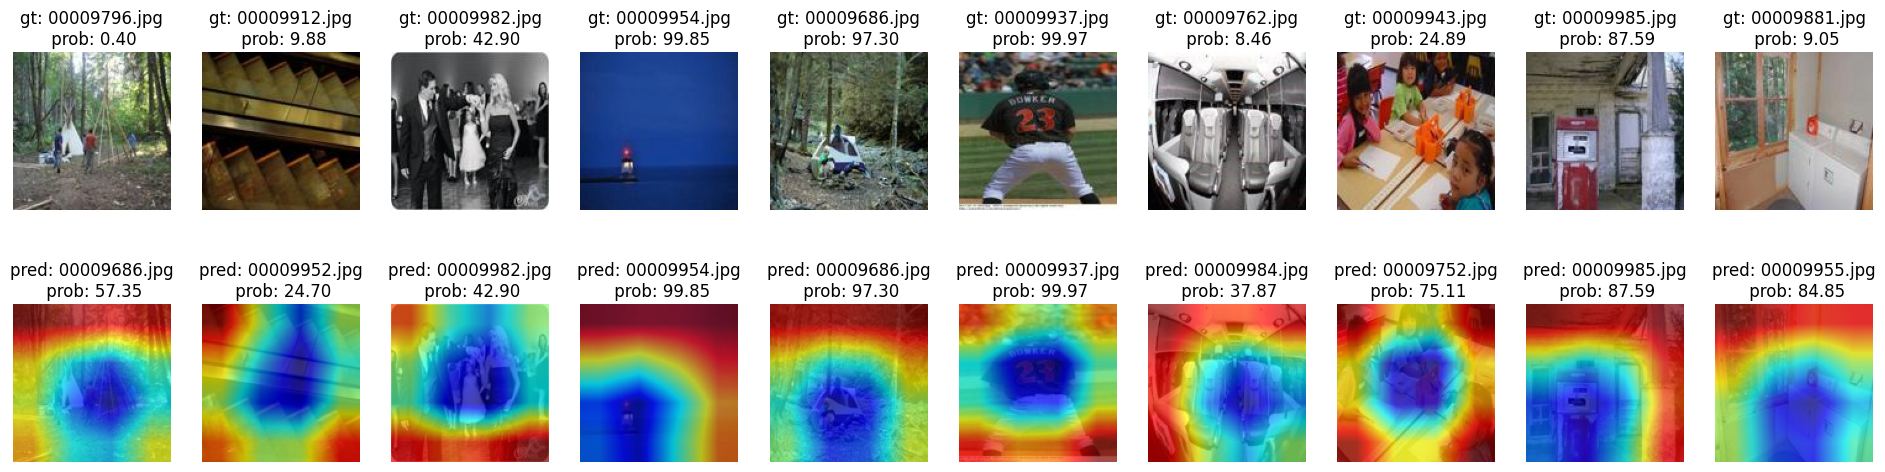

In [ ]:
import matplotlib.pyplot as plt

seed_everything(0)
resnet_finetune3.eval()

finalconv_name = 'layer4'
# hook the feature extractor
features_blobs = []


def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())


resnet_finetune3.resnet._modules.get(finalconv_name).register_forward_hook(
    hook_feature)

params = list(resnet_finetune3.parameters())
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())
print(weight_softmax.shape)
classes = []
for i in range(100):
    classes.append(str(i))

val_sub_dataset = torch.utils.data.Subset(
    miniplaces_val, np.random.choice(np.arange(len(miniplaces_val)), 10,
                                     False))
val_sub_loader = torch.utils.data.DataLoader(val_sub_dataset,
                                             batch_size=1,
                                             num_workers=num_workers,
                                             shuffle=False)

figure = plt.figure(figsize=(24, 6))
cols, rows = 10, 2
counter = 0

for i, data in enumerate(tqdm((val_sub_loader))):
    features_blobs = []
    img, label = data
    img = img.cuda()

    logit = resnet_finetune3(img)

    h_x = F.softmax(logit, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.cpu().numpy()
    idx = idx.cpu().numpy()

    # generate class activation mapping for the top1 prediction
    CAMs = CAM(features_blobs[0], weight_softmax, [idx[0]])
    img = img.squeeze().permute(1, 2, 0)
    height, width, _ = img.shape
    img = img.cpu() * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor(
        [0.485, 0.456, 0.406])
    img = img.cpu().numpy()
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0], (width, height)),
                                cv2.COLORMAP_JET)
    heatmap = heatmap / 255
    result = heatmap * 0.7 + img * 0.3

    figure.add_subplot(rows, cols, i + 1)
    plt.axis("off")
    plt.title(
        f"gt: {miniplaces_val.label_dict[label.item()]}\n prob: {h_x[label.item()].item()*100:.2f}"
    )
    plt.imshow(img, cmap="gray")

    figure.add_subplot(rows, cols, i + 11)
    plt.axis("off")
    plt.title(
        f"pred: {miniplaces_val.label_dict[idx[0]]}\n prob: {probs[0]*100:.2f}"
    )

    plt.imshow(result, cmap="gray")
    counter += 1

plt.show()

### Q2.4 Answer the following questions (15 pts)

a: Compare the results of using MLPs in Q3 of Assignment 1, FastConv in Q1, and ResNet in Q2. In 2-3 sentences, explain the differences in these model architectures and how such differences leads to the performance gap between these models. (5 pts)

(Double click to edit)

Your Answer:

ResNet is signicantly better than FastConv and MLP. MLP did not have convolutional layers which made it not as suited for vision tasks. FastConv used convolution, but had problems with identity mapping. ResNet added a residual term that skipped the convolution to make identity mappings (if its the correct weight) easier to reach.


---

b: Compare the results of Q2.1, Q2.2.2, Q2.2.3, Q2.2.4, and Q2.2.5? Why finetuning performs better than training from scratch on ResNet-18? Which finetuning techniques gives you the best accuracy? Which finetuning techniques gives you the worst accuracy? Use one sentence to explain the accuracy ordering for each finetuning method. (5 pts)

(Double click to edit)

Your Answer:

The pretrained have probably already been trained for a long time, with numerous different hyperparameters tuning in place.The pretrained model of course will perform better because of the much better initial weights.

In summary,  Q2.1 < Q2.2.2 < Q2.2.3 < Q2.2.4 < Q2.2.5 in terms of accuracy

---

c: In 2-3 sentences, describe what you observe from the class activation mapping in Q2.3, where is the CNN "looking at" in those images? Give 1-2 examples from the visualizations. (5 pts)

(Double click to edit)

Your Answer:

CNN seems to focus on some feature within the images that inidcates what class it is. For example, in the picture with the light house, the model focuses on the light house on the bottom left corner. In the mail post image, the model focuses on the mail post on the bottom left more than the rest of the image.

---

## Q3: Your own model (20 pts)

In this question, you will train your own CNN on MiniPlaces. You can base your model on the pretrained `ResNet-18` weights, and modify the learning rate, optimizer, and other parameters during finetuning. You may also want to implement other training techniques such as data augmentation. But feel free to try other CNN architectures. You should write this model in the following code cells.

You will select the best model using the validation set, and then evaluate it on the test set.  You should create a file named "test_UID.json", containing "{id: predicted_label}" pairs. You may also try model assembly or test-time augmentation to further improve the performance.

You may also need to modify the previous MiniPlaces dataset to also load test images from `{root_dir}/images/test`.

We will hold a leaderboard of the test accuracy on [Kaggle](https://www.kaggle.com/t/5dfa88fa7eb94cb880cfbd1c9194352f). See the instructions on the website for submission to the leaderboard. The top 20% of students can receive a bonus. Don't worry, you shall receive a full credit for this question as long as your model has better accuracy than the finetuning baseline.

Feel free to organize your code in different ways. In this question, you do not have to follow the `#Your Implementations#` comments. Below is just an example of one possible organization for your code.

**Your code should be trainable on Colab**, we do not expect you to use additional resources to train your model, and your code should give similar test accuracies to the ones you posted on the leaderboard.

In [ ]:
# Define your model.

class Kaggle(nn.Module):

    def __init__(self, mode='finetune', num_classes=100):
        super().__init__()
        """
        use the resnet18 model from torchvision models. Remember to set pretrained as true

        mode has two options:
        1) linear: For this model, we want to freeze resnet18 features, then train a linear
            classifier which takes the features before resnet.fc (we do not want
            the pretrained resnet.fc for 1000 classes). And then write our own FC layer: which takes in the features and
            output scores of size 100 (because we have 100 categories).
            Because we want to freeze resnet18 features, we have to iterate through parameters()
            of our model, and manually set some parameters to requires_grad = False
            Or use other methods to freeze the features
        2) finetune: Same as 1), except that we we do not need to freeze the features and
           can finetune on the pretrained resnet model.
        """
        ################# Your Implementations #################################
        self.mode = mode
        import torch
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
        # model.eval()
        # self.resnet = models.resnet51(pretrained=True)
        if mode=='linear':
          for param in self.resnet.parameters():
              param.requires_grad = False
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

        ################# End of your Implementations ##########################

    def forward(self, x):
        ################# Your Implementations #################################
        x = self.resnet(x)
        ################# End of your Implementations ##########################
        return x

    def to(self, device):
        return self.resnet.to(device=device)

In [ ]:
# Build train/val/test datasets and data loaders using the modules we built before.
import os

from torch.utils.data import DataLoader, Dataset


import os

from torch.utils.data import DataLoader, Dataset

import pandas as pd

class MiniPlacesTest(Dataset):

    def __init__(self, root_dir, transform=None, label_dict=None):
        """
        Initialize the MiniPlaces dataset with the root directory for the images,
        the split (train/val/test), an optional data transformation,
        and an optional label dictionary.

        Args:
            root_dir (str): Root directory for the MiniPlaces images.
            split (str): Split to use ('train', 'val', or 'test').
            transform (callable, optional): Optional data transformation to apply to the images.
            label_dict (dict, optional): Optional dictionary mapping integer labels to class names.
        """
        self.root_dir = root_dir
        self.split = "test"
        self.transform = transform
        self.filenames = []
        self.labels = []

        # Take a second to think why we need this line.
        # Hints: training set / validation set / test set.
        self.label_dict = label_dict if label_dict is not None else {}

        # You should
        #   1. Load the train/val/test text file based on the `split` argument and
        #     store the image filenames and labels.
        #   2. Extract the class names from the image filenames and store them in
        #     self.label_dict.
        #   3. Construct a label dict that maps integer labels to class names, if
        #     the current split is "train"
        ################# Your Implementations #################################
        if self.split == 'train':
            loaded_file = pd.read_csv(os.path.join(root_dir, "train.txt"), delim_whitespace=True, header=None)
            self.filenames = loaded_file[0]
            self.labels = loaded_file[1]
            # loaded_file[0] = loaded_file[0].apply(lambda x:x.split("/")[2])
            # loaded_file = loaded_file.group_by([0])
            # label_dict = loaded_file.set_index(1).to_dict('list')
            # print(label_dict)
            for i in range (len(self.labels)):
                self.label_dict[self.labels[i]] = self.filenames[i].split("/")[2]

        if self.split == 'val':
            loaded_file = pd.read_csv(os.path.join(root_dir, "val.txt"), delim_whitespace=True, header=None)
            self.filenames = loaded_file[0]
            self.labels = loaded_file[1]
        else:
            self.filenames = ["test/" + x for x in os.listdir(os.path.join(root_dir, "images/test/"))]
            self.labels = [str(int(x.split(".jpg")[0])) for x in os.listdir(os.path.join(root_dir, "images/test/"))]
            print(self.filenames)
            print(self.labels)
        ################# End of your Implementations ##########################

    def __len__(self):
        """
        Return the number of images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        dataset_len = 0
        ################# Your Implementations #################################
        # Return the number of images in the dataset
        dataset_len = len(self.filenames)
        ################# End of your Implementations ##########################
        return dataset_len

    def __getitem__(self, idx):
        """
        Return a single image and its corresponding label when given an index.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            tuple: Tuple containing the image and its label.
        """
        ################# Your Implementations #################################
        # Load and preprocess image using self.root_dir,
        # self.filenames[idx], and self.transform (if specified)
        img_path = os.path.join(self.root_dir,"images", self.filenames[idx])
        image = Image.open(img_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        ################# End of your Implementations ##########################
        return image, label


data_root = os.path.join(root_dir, 'data')
# Create MiniPlaces test dataset object
miniplaces_test = MiniPlacesTest(data_root, transform=data_transform)

# Create DataLoader for test set
test_loader = DataLoader(miniplaces_test,
                         batch_size=batch_size,
                         num_workers=num_workers,
                         shuffle=False)

['test/00005408.jpg', 'test/00008291.jpg', 'test/00000858.jpg', 'test/00004689.jpg', 'test/00007713.jpg', 'test/00000003.jpg', 'test/00005268.jpg', 'test/00004032.jpg', 'test/00002469.jpg', 'test/00001654.jpg', 'test/00001829.jpg', 'test/00001595.jpg', 'test/00008814.jpg', 'test/00003318.jpg', 'test/00002260.jpg', 'test/00004459.jpg', 'test/00008909.jpg', 'test/00003114.jpg', 'test/00002373.jpg', 'test/00005846.jpg', 'test/00003687.jpg', 'test/00008978.jpg', 'test/00002623.jpg', 'test/00001233.jpg', 'test/00007383.jpg', 'test/00004693.jpg', 'test/00004365.jpg', 'test/00003266.jpg', 'test/00009790.jpg', 'test/00006369.jpg', 'test/00002896.jpg', 'test/00002243.jpg', 'test/00009381.jpg', 'test/00005086.jpg', 'test/00009383.jpg', 'test/00006134.jpg', 'test/00002688.jpg', 'test/00004939.jpg', 'test/00003713.jpg', 'test/00007000.jpg', 'test/00009797.jpg', 'test/00000013.jpg', 'test/00008215.jpg', 'test/00005346.jpg', 'test/00008000.jpg', 'test/00009870.jpg', 'test/00007803.jpg', 'test/000090

In [ ]:
# Train on the training set, validate on the validation set.
# Search hyper-parameters to find the best model on the validation set.

seed_everything(0)

kaggle_transform = v2.Compose([
    transforms.Resize((128, 128)),  # Resize image to 128x128
    v2.ToTensor(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_root = os.path.join(root_dir, 'data')
# Create MiniPlaces dataset object
kaggle_train = MiniPlaces(data_root,
                              split='train',
                              transform=kaggle_transform)

kaggle_val = MiniPlaces(data_root,
                            split='val',
                            transform=kaggle_transform,
                            label_dict=miniplaces_train.label_dict)

# Create the dataloaders
# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Create DataLoader for training and validation sets
kaggle_train_loader = DataLoader(kaggle_train,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          shuffle=True)
kaggle_val_loader = DataLoader(kaggle_val,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=False)

# # Define the model, optimizer, and criterion (loss_fn)
kaggle2 = Kaggle(mode='finetune', num_classes=len(miniplaces_train.label_dict))

optimizer = None
################# Your Implementations #########################################

optimizer = torch.optim.SGD([
                {'params': [param for name, param in kaggle2.named_parameters() if ('fc' not in name and 'layer1' not in name and 'layer2' not in name)]},
                {'params': kaggle2.resnet.layer1.parameters(), 'lr':0},
                {'params': kaggle2.resnet.layer2.parameters(), 'lr':0},
                {'params': kaggle2.resnet.fc.parameters(), 'lr': 0.01}
            ], lr=0.001, momentum=0.9)

# ################# End of your Implementations ##################################

criterion = nn.CrossEntropyLoss()
torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

# # Train the model
# train(kaggle2,
#       train_loader,
#       val_loader,
#       optimizer,
#       criterion,
#       device,
#       num_epochs=1)
# # Train the model
train(kaggle2,
      kaggle_train_loader,
      kaggle_val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=3)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/3:

Validation set: Average loss = 1.5907, Accuracy = 0.5649


Epoch 2/3: 100%|██████████| 1563/1563 [01:11<00:00, 22.01it/s, loss=1.35]


Validation set: Average loss = 1.5727, Accuracy = 0.5849


Epoch 3/3: 100%|██████████| 1563/1563 [01:11<00:00, 21.83it/s, loss=1.19]


Validation set: Average loss = 1.6571, Accuracy = 0.5855


In [ ]:

optimizer = torch.optim.SGD([
                {'params': [param for name, param in kaggle2.named_parameters() if ('fc' not in name and 'layer1' not in name and 'layer2' not in name)]},
                {'params': kaggle2.resnet.layer1.parameters(), 'lr':0.001},
                {'params': kaggle2.resnet.layer2.parameters(), 'lr':0.001},
                {'params': kaggle2.resnet.fc.parameters(), 'lr': 0.000001}
            ], lr=0.00001, momentum=0.9)

# ################# End of your Implementations ##################################

criterion = nn.CrossEntropyLoss()
torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

train(kaggle2,
      kaggle_train_loader,
      kaggle_val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=3)

Epoch 1/3: 100%|██████████| 1563/1563 [01:11<00:00, 21.78it/s, loss=0.73]


Validation set: Average loss = 1.5687, Accuracy = 0.6021


Epoch 2/3: 100%|██████████| 1563/1563 [01:11<00:00, 21.76it/s, loss=0.918]


Validation set: Average loss = 1.5733, Accuracy = 0.6004


Epoch 3/3: 100%|██████████| 1563/1563 [01:12<00:00, 21.49it/s, loss=0.576]


Validation set: Average loss = 1.5378, Accuracy = 0.6085


In [ ]:
# Generate test-set results.


def test(model, test_loader):
    """
    Evaluate the MLP classifier on the test set.

    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        out_dict: prediction result on the test set
    """
    model.eval()  # Set model to evaluation mode
    out_dict = {}

    with torch.no_grad():
        for inputs, ids in test_loader:
            #     for inputs, labels in test_loader:
            # # Move inputs and labels to device
            # inputs = inputs.to(device)
            # labels = labels.to(device)

            # # Compute the logits and loss
            # logits = model(inputs)
            # loss = criterion(logits, labels)
            # total_loss += loss.item()

            # # Compute the accuracy
            # _, predictions = torch.max(logits, dim=1)
            # num_correct += (predictions == labels).sum().item()
            # num_samples += len(inputs)

            ################# Your Implementations #############################
            # similar to the evaluate function
            # first compute the output logits and then get the predicted class with maximum probability
            # save the id and the prediction to out_dict
            # Move inputs and labels to device
            inputs = inputs.to(device)

            # Compute the logits and loss
            logits = model(inputs)

            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            for z in range(len(ids)):
              out_dict[ids[z]] = predictions[z].item()

            ################# End of your Implementations ######################
    return out_dict

In [ ]:
# Convert the test-set results dictionary to a CSV file:

import csv

test_output = test(kaggle2, test_loader)
print(len(test_output))
# assert len(test_output) == 10000
# update your csv file name for submissioin
csv_name = "sean.csv"

# now we will open a file for writing
data_file = open(os.path.join(root_dir, csv_name), 'w')

# create the csv writer object
csv_writer = csv.writer(data_file)

# Counter variable used for writing
# headers to the CSV file
count = 0

header = ['Id', 'Category']

for key, value in test_output.items():
    if count == 0:
        # Writing headers of CSV file
        header = header
        csv_writer.writerow(header)
        count += 1

    # Writing data of CSV file
    csv_writer.writerow([key, str(value)])

data_file.close()
print("succesfully saved the test csv file at: " +
      os.path.join(root_dir, csv_name))

from google.colab import files

files.download(os.path.join(root_dir, csv_name))

10000
succesfully saved the test csv file at: ./CS188_W24/Assignment2/sean.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Please report your test accuracy on the public leaderboard:

(Double click to edit)

Your Answer:

My highest so far is 57.5%. I think I can push it to 60% in the future (after my 5 limit a day is lifted).

---

In one paragraph, shortly summarize your method and your improvement and modifications made upon the baseline:

(Double click to edit)

Your Answer:

I used a different variant of resnet, and decided after 3 epochs of training on the original hyper parmeters, I will "unfreeze" layer1 and layer2 to get a better effect.

I also conducted data augmentation on the input via random horizontal flips.

---